In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.8.0


In [2]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [3]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


In [4]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [5]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [6]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


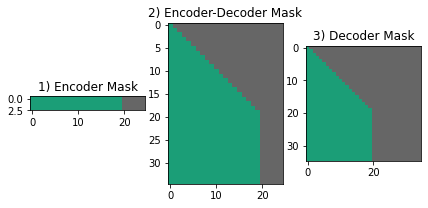

In [7]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [8]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


In [9]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.8.0
1.21.5
3.2.2


In [12]:
!ls

drive  sample_data


In [14]:
data_dir = './drive/MyDrive/Colab Notebooks/data/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # [[YOUR CODE]]
    raw = zip(kor, eng) # 한국 문장과 영어 문장이 대응되기 때문에 zip을 쓴 다음 set을 써야 만족스러운 결과가 나온다. 
    cleaned_corpus = set(raw)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [16]:
kor_corpus, eng_corpus = zip(*cleaned_corpus)
print(len(kor_corpus), len(eng_corpus))

78968 78968


In [17]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip() # 모든 입력을 소문자로 변환합니다.

    #문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # \1은 정규식의 그룹 중 첫 번째 그룹을 가리킨다.
    sentence = re.sub(r'[" "]+', " ", sentence) #문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = re.sub(r"[^a-z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)# 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.

    sentence = sentence.strip()
    
    return sentence

In [18]:
enc_corpus = []
dec_corpus = []

for kor, eng in zip(kor_corpus, eng_corpus):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng)

    enc_corpus.append(temp_kor)
    dec_corpus.append(temp_eng)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500])  

korean data size: 78968
english data size: 78968
Korean: 이에따라 이 미국 자동차 회사의 구제를 위한 이탈리아 피아트와의 최종 협상이 가능해 질 것으로 보입니다 .
English: a new report says consumer confidence soared in april amid signs the economy is starting to stabilize .


In [19]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 9.3 MB/s 


In [28]:
!pip install sentencepiece==0.1.83



     |████████████████████████████████| 1.0 MB 18.5 MB/s 
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.96
    Uninstalling sentencepiece-0.1.96:
      Successfully uninstalled sentencepiece-0.1.96


In [29]:
import sentencepiece as spm

In [42]:
spm.SentencePieceTrainer.train("--input={} --model_prefix={} --vocab_size={}".format(kor_corpus, 'ko', 20000)) 

OSError: ignored

In [41]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    vocab_size = 20000
    spm.SentencePieceTrainer.train("--input={} --model_prefix={} --vocab_size={}".format(corpus, lang, vocab_size),) 

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000


ko_tokenizer = generate_tokenizer(enc_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(dec_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

OSError: ignored